## Решение задачи кредитного скоринга с использованием полностью гомоморфного шифрования

### Введение

В данной работе рассматривается ситуация нехватки вычислительной мощности для решения задач машинного обучения, поэтому было принято решение арендовать для этих целей облачный сервер. 

Однако так как данные передаются на сторонний сервер, то возникает проблема безопасности данных, так как уязвимости в самом облаке, возможности несанкционированного доступа или даже неправильная настройка доступа к облаку могут привести к угрозам информационной безопасности, например, утечке данных, что снизит уровень доверия клиентов, а также приведёт к репутационным потерям и штрафам за нарушение правил информационной безопасности.

Решить данную проблему можно с помощью машинного обучения на зашифрованных данных, которое возможно с использованием полностью гомоморфного шифрования, позволяющего выполнять вычисления над зашифрованными данными без их расшифровки, что обеспечивает наивысший уровень безопасности, так как содержание данных никогда не раскрывается.

Демонстрация применения полностью гомоморфного шифрования для машинного обучения предлагается на примере решения задачи кредитного скоринга с предварительным шифрованием данных на стороне клиента (этап 1) и обучением и оценкой модели на зашифрованных данных на стороне сервера (этап 2). 

В качестве библиотеки полностью гомоморфного шифрования выбрана TenSEAL, основанная на Microsoft SEAL, которая в настоящее время является наиболее используемой библиотекой полностью гомоморфного шифрования. С помощью API она обеспечивает простоту использования языка Python, при этом сохраняя эффективность за счет реализации большинства операций с использованием C++.

### Этап 1 - Подготовка данных (клиент)

**Импорт библиотек**

In [2]:
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tenseal as ts
import torch
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from time import time

#### 1 Чтение данных

Набор данных [Credit score classification](https://www.kaggle.com/datasets/parisrohan/credit-score-classification/data), скачанный с Kaggle, выбран потому, что он включает в себя практически полную информацию о банковских клиентах, в том числе, возраст, профессию, годовой и ежемесячный доход, количество банковских счетов и так далее.

In [3]:
df = pd.read_csv('Credit score data.csv', low_memory=False)
df.tail()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
99995,0x25fe9,CUS_0x942c,April,Nicks,25,078-73-5990,Mechanic,39628.99,3359.415833,4,...,_,502.38,34.663572,31 Years and 6 Months,No,35.104023,60.97133255718485,High_spent_Large_value_payments,479.86622816574095,Poor
99996,0x25fea,CUS_0x942c,May,Nicks,25,078-73-5990,Mechanic,39628.99,3359.415833,4,...,_,502.38,40.565631,31 Years and 7 Months,No,35.104023,54.18595028760385,High_spent_Medium_value_payments,496.651610435322,Poor
99997,0x25feb,CUS_0x942c,June,Nicks,25,078-73-5990,Mechanic,39628.99,3359.415833,4,...,Good,502.38,41.255522,31 Years and 8 Months,No,35.104023,24.02847744864441,High_spent_Large_value_payments,516.8090832742814,Poor
99998,0x25fec,CUS_0x942c,July,Nicks,25,078-73-5990,Mechanic,39628.99,3359.415833,4,...,Good,502.38,33.638208,31 Years and 9 Months,No,35.104023,251.67258219721603,Low_spent_Large_value_payments,319.1649785257098,Standard
99999,0x25fed,CUS_0x942c,August,Nicks,25,078-73-5990,Mechanic,39628.99_,3359.415833,4,...,Good,502.38,34.192463,31 Years and 10 Months,No,35.104023,167.1638651610451,!@9#%8,393.6736955618808,Poor


#### 2 Очистка данных

##### 2.1 Предварительная очистка данных

In [4]:
print('Размер набора данных: ', df.shape)

Размер набора данных:  (100000, 28)


Определим количество пропущенных значений.

In [5]:
df.isnull().sum() / len(df) * 100

ID                           0.000
Customer_ID                  0.000
Month                        0.000
Name                         9.985
Age                          0.000
SSN                          0.000
Occupation                   0.000
Annual_Income                0.000
Monthly_Inhand_Salary       15.002
Num_Bank_Accounts            0.000
Num_Credit_Card              0.000
Interest_Rate                0.000
Num_of_Loan                  0.000
Type_of_Loan                11.408
Delay_from_due_date          0.000
Num_of_Delayed_Payment       7.002
Changed_Credit_Limit         0.000
Num_Credit_Inquiries         1.965
Credit_Mix                   0.000
Outstanding_Debt             0.000
Credit_Utilization_Ratio     0.000
Credit_History_Age           9.030
Payment_of_Min_Amount        0.000
Total_EMI_per_month          0.000
Amount_invested_monthly      4.479
Payment_Behaviour            0.000
Monthly_Balance              1.200
Credit_Score                 0.000
dtype: float64

Наибольшее количество пропущенных значений находятся в полях:
* 15 % - Monthly_Inhand_Salary;
* 11 % - Type_of_Loan;
* 9 % - Name и Credit_History_Age;
* 7 % - Num_of_Delayed_Payment. 

In [6]:
df.describe(exclude=np.number).T

,count,unique,top,freq
ID,100000,100000,0x1602,1
Customer_ID,100000,12500,CUS_0xd40,8
Month,100000,8,January,12500
Name,90015,10139,Langep,44
Age,100000,1788,38,2833
SSN,100000,12501,#F%$D@*&8,5572
Occupation,100000,16,_______,7062
Annual_Income,100000,18940,36585.12,16
Num_of_Loan,100000,434,3,14386
Type_of_Loan,88592,6260,Not Specified,1408


Выводы:
* 12500 уникальных значений поля с идентификатором клиента Customer_ID означают то, что в наборе представлены данные 12500 клиентов.
* 8 уникальных значений поля с месяцем Month означают то, что данные представлены не за все месяцы.
* 1788 уникальных значений поля с возрастом Age выглядят странно.
* 12501 уникальных значений поля с номером социального страхования SNN при наличии данных о 12500 клиентах означают то, что у одного из клиентов представлен неправильный SNN.
* Данные содержат лишние символы, например, "_".

Удалим поля, не влияющие на кредитный рейтинг.

In [7]:
df.drop(['ID', 'Customer_ID', 'Name', 'SSN', 'Month'], axis=1, inplace=True)

Удалим лишние символы из данных.

In [8]:
def text_cleaning(data):
    if data is np.NaN or not isinstance(data, str):
        return data
    else:
        return str(data).strip('_ ,"')

In [9]:
df = df.map(text_cleaning)

In [10]:
columns = df.columns.to_list()
for col in columns:
    df[col] = df[col].map(text_cleaning)

Заменим не имеющие смысла значений на NaN.

In [11]:
df = df.replace(['', 'nan', '!@9#%8'], np.NaN)

Определим и преобразуем типы данных.

In [12]:
df.dtypes

Age                          object
Occupation                   object
Annual_Income                object
Monthly_Inhand_Salary       float64
Num_Bank_Accounts             int64
Num_Credit_Card               int64
Interest_Rate                 int64
Num_of_Loan                  object
Type_of_Loan                 object
Delay_from_due_date           int64
Num_of_Delayed_Payment       object
Changed_Credit_Limit         object
Num_Credit_Inquiries        float64
Credit_Mix                   object
Outstanding_Debt             object
Credit_Utilization_Ratio    float64
Credit_History_Age           object
Payment_of_Min_Amount        object
Total_EMI_per_month         float64
Amount_invested_monthly      object
Payment_Behaviour            object
Monthly_Balance              object
Credit_Score                 object
dtype: object

Выводы:
* Данные представлены строковым и числовым типом.
* Числовые поля Age, Annual_Income, Num_of_Loan, Num_of_Delayed_Payment, Changed_Credit_Limit, Outstanding_Debt, Amount_invested_monthly, Monthly_Balance представлены неверным типом.

In [13]:
wrong_types = ['Age', 'Annual_Income', 'Num_of_Loan', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
               'Outstanding_Debt', 'Amount_invested_monthly', 'Monthly_Balance'
            ]

In [14]:
for col in wrong_types:
    df[col] = df[col].astype('float64')

С помощью функции convert_to_month() конвертируем значения поля Credit_History_Age, представленные годами и месяцами, в месяцы (например, "2 Years and 7 Months" в "19") и преобразуем в тип float64.

In [15]:
def convert_to_months(history):
    if pd.notnull(history):
        years = int(history.split(' ')[0])
        months = int(history.split(' ')[3])
        return (years * 12) + months
    return 0

In [16]:
df['Credit_History_Age'] = df['Credit_History_Age'].apply(lambda x: convert_to_months(x)).astype(float)

##### 2.2 Обработка количественных данных

In [17]:
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns.to_list()

for col in numerical_columns:
    print(df[col].value_counts())
    print('_______________________')

Age
38.0      2994
28.0      2968
31.0      2955
26.0      2945
32.0      2884
          ... 
1908.0       1
4583.0       1
7549.0       1
3119.0       1
1342.0       1
Name: count, Length: 1728, dtype: int64
_______________________
Annual_Income
17816.75       16
22434.16       16
40341.16       16
17273.83       16
109945.32      16
               ..
17079092.00     1
1910572.00      1
20179076.00     1
7980216.00      1
8299495.00      1
Name: count, Length: 13487, dtype: int64
_______________________
Monthly_Inhand_Salary
6769.130000    15
6358.956667    15
2295.058333    15
6082.187500    15
3080.555000    14
               ..
1087.546445     1
3189.212103     1
5640.117744     1
7727.560450     1
2443.654131     1
Name: count, Length: 13235, dtype: int64
_______________________
Num_Bank_Accounts
6       13001
7       12823
8       12765
4       12186
5       12118
        ...  
1626        1
1470        1
887         1
211         1
697         1
Name: count, Length: 943, dtype: 

Обработаем отрицательные значения, заменив их на NaN.

In [18]:
for col in numerical_columns:
    df[col] = df[col].map(lambda x: np.NaN if x < 0 else x)

В поле Age представлено 1788 уникальных значений, но возраст должны быть целым числом от 18 до 85 (максимальный возраст заёмщика).

In [19]:
df = df.loc[(df['Age'] >= 18 ) & (df['Age'] <= 85)]

Также отбросим выбросы и ограничим диапазон других значений, так как, например, у клиента не может быть 1118 кредитных карт или 2397 кредитных запросов.

In [20]:
df = df[df['Interest_Rate'] <= 50]
df = df[df['Num_of_Loan'] <= 12]
df = df[df['Num_Credit_Card'] <= 10]
df = df[df['Num_Bank_Accounts'] <= 10]
df = df[df['Delay_from_due_date'] <= 60]
df = df[df['Changed_Credit_Limit'] <= 30]
df = df[df['Num_Credit_Inquiries'] <= 12]
df = df[df['Total_EMI_per_month'] <= 200]
df = df[df['Outstanding_Debt'] <= 1500]

Рассчитаем пропущенные значения в полях Monthly_Inhand_Salary, Num_of_Delayed_Payment, Amount_invested_monthly и Monthly_Balance как среднее арифметическое.

In [21]:
null_num_columns = ['Monthly_Inhand_Salary', 'Num_of_Delayed_Payment', 'Amount_invested_monthly', 'Monthly_Balance']
imputer = SimpleImputer(strategy='mean')
df[null_num_columns] = imputer.fit_transform(df[null_num_columns])

##### 2.3 Обработка категориальных данных

In [22]:
categorical_columns = df.select_dtypes(include=['object']).columns.to_list()

for col in categorical_columns:
    print(df[col].value_counts())
    print('_______________________')

Occupation
Lawyer           3070
Architect        2950
Media_Manager    2774
Teacher          2742
Accountant       2740
Developer        2721
Entrepreneur     2684
Journalist       2683
Musician         2683
Mechanic         2681
Scientist        2679
Manager          2650
Engineer         2638
Doctor           2637
Writer           2578
Name: count, dtype: int64
_______________________
Type_of_Loan
Not Specified                                                                                                                                   1026
Personal Loan                                                                                                                                    972
Student Loan                                                                                                                                     957
Credit-Builder Loan                                                                                                                              933


Поле Payment_of_Min_Amount может содержать только значения "Yes" или "No", но не может содержать "NM".

In [23]:
df.loc[df['Payment_of_Min_Amount'] == 'NM', 'Payment_of_Min_Amount'] = np.NaN

Значения поля Type_of_Loan содержат ненужный союз "and".

In [24]:
df['Type_of_Loan'] = df['Type_of_Loan'].apply(lambda x: x.lower().replace('and ', '').replace(', ', ',').strip() if pd.notna(x) else x)

В поле Credit_Score нет пропущенных значений и оно принимает значения Good, Poor и Standard, поэтому сразу преобразуем их в числа.

In [25]:
score_map = {'Poor': 0, 'Standard': 1, 'Good': 1}
df['Credit_Score'] = df['Credit_Score'].map(score_map)
df['Credit_Score'].value_counts()

Credit_Score
1    37965
0     6073
Name: count, dtype: int64

Закодируем числами строковые категориальные данные.

In [26]:
cat_columns = ['Payment_of_Min_Amount','Payment_Behaviour', 'Type_of_Loan', 'Occupation', 'Credit_Mix']
encoder = ce.LeaveOneOutEncoder()
for col in cat_columns:
    df[col] = encoder.fit_transform(df[col], df['Credit_Score'])

##### 2.5 Проверка на наличие пропущенных и повторяющихся значений

In [27]:
if df.isnull().sum().sum() == 0:
    print('Пропущенных значений нет.')
else:
    print('Пропущенных значений: ', df.isnull().sum().sum())

Пропущенных значений нет.


In [28]:
if len(df)- len(df.drop_duplicates()) == 0:
    print('Повторяющихся значений нет.')
else:
    print('Повторяющихся значений: ', len(df)- len(df.drop_duplicates()))

Повторяющихся значений нет.


##### 2.7 Корреляция данных

[]

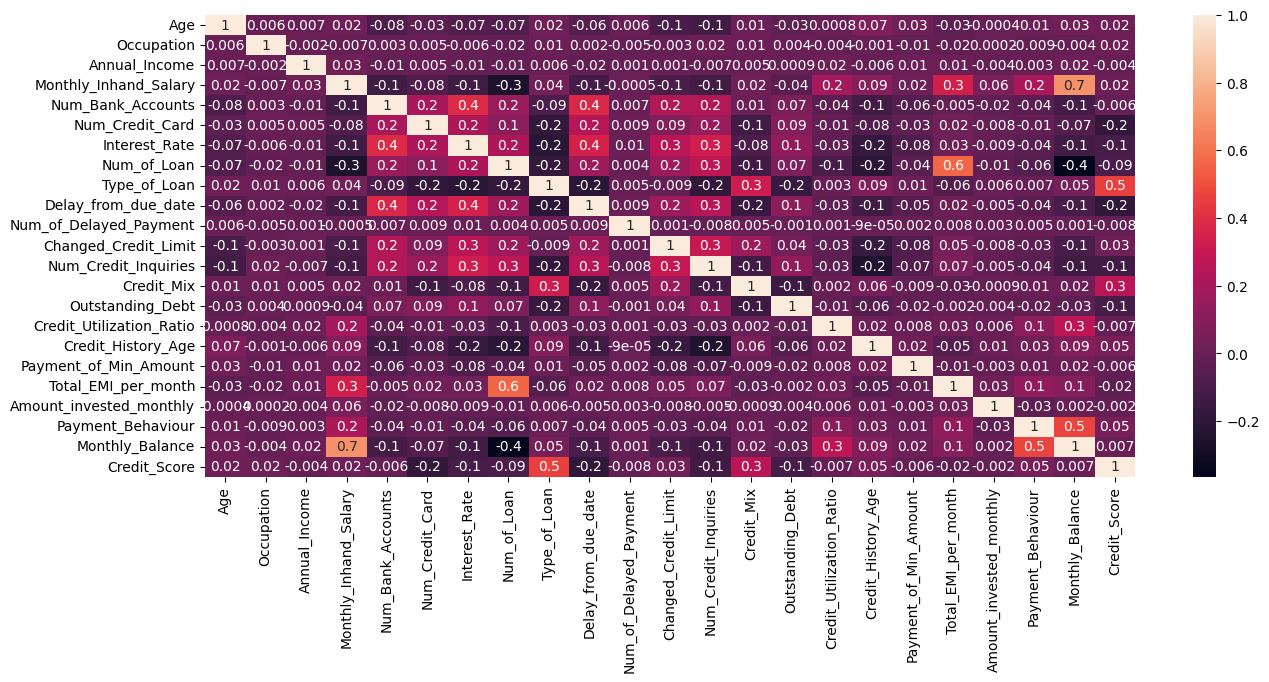

In [29]:
corr = df.corr()
fig, ax = plt.subplots(figsize=(15, 6))
sns.heatmap(corr, ax=ax, xticklabels=corr.columns, yticklabels=corr.columns, fmt ='.1g', annot=True)
plt.plot()

Для того, чтобы избежать мультиколлинеарности, то есть высокой степени взаимосвязи между признаками, которая может стать причиной переобучаемости модели, что приведет к неверному результату, поэтому определим поля с высоким коэффициентом корреляции (больше 0.6):
* Monthly_Inhand_Salary и Monthly_Balance
* Num_of_Loan и Total_EMI_per_month
* Credit_Mix и Payment_of_Min_Amount  
Удалим поля Monthly_Balance, Total_EMI_per_month и Payment_of_Min_Amount, так как о них можно делать выводы по другим полям и они наименьшим образом влияют на целевую переменную.

In [30]:
df = df.drop(columns=[
    "Monthly_Balance",
    "Total_EMI_per_month", 
    "Payment_of_Min_Amount",
])

In [31]:
print('Размер очищенного набора данных: ', df.shape)

Размер очищенного набора данных:  (44038, 20)


##### 2.7 Нормализация данных

In [32]:
columns_list = df.columns.to_list()
scaler = MinMaxScaler()

for col in columns_list:
    df[col] = scaler.fit_transform(df[[col]])

df.describe()

,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Amount_invested_monthly,Payment_Behaviour,Credit_Score
count,44038.000000,44038.000000,44038.000000,44038.000000,44038.000000,44038.000000,44038.000000,44038.000000,44038.000000,44038.000000,44038.000000,44038.000000,44038.000000,44038.000000,44038.000000,44038.000000,44038.000000,44038.000000,44038.000000,44038.000000
mean,0.466982,0.561792,0.007040,0.269427,0.438860,0.478739,0.278289,0.243853,0.862405,0.247646,0.006622,0.321757,0.317913,0.931390,0.516099,0.406787,0.608087,0.062906,0.554685,0.862096
std,0.280047,0.279701,0.058854,0.194615,0.230519,0.167751,0.178117,0.187159,0.176128,0.154357,0.049734,0.185320,0.231798,0.127671,0.295168,0.178992,0.269255,0.197074,0.387771,0.344803
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.236842,0.427030,0.000627,0.122199,0.300000,0.400000,0.151515,0.111111,0.858670,0.133333,0.001819,0.174397,0.166667,0.891224,0.258500,0.259180,0.487624,0.008070,0.213684,1.000000
50%,0.447368,0.545898,0.001245,0.230258,0.400000,0.500000,0.242424,0.222222,0.879396,0.216667,0.002729,0.310575,0.250000,0.932444,0.518681,0.406904,0.638614,0.014815,0.723416,1.000000
75%,0.684211,0.710619,0.002814,0.353972,0.600000,0.600000,0.393939,0.333333,1.000000,0.350000,0.003866,0.429314,0.500000,0.999924,0.784529,0.553138,0.819307,0.030630,0.868739,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


##### 2.7 Сохранение обработанных данных в формате CSV

In [33]:
sample_df = df.sample(frac=0.1)
sample_df.to_csv("Prepared credit score data.csv", index=False)

#### 3 Шифрование данных

##### 3.1 Разделение данных

In [34]:
x = sample_df.drop(columns=['Credit_Score'])
y = sample_df['Credit_Score'].copy()

In [35]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

##### 3.2 Шифрование данных

Для шифрования данных предлагается использовать схему CKKS, так как она позволяет работать с вещественными числами, которыми представлены данные. 
Параметры шифрования схемы CKKS включают в себя:
* степень полиномиального модуля;
* размеры модуля коэффициента.

Определим значения параметров шифрования, для чего сначала определим количество необходимых операций умножения:
* для операции скалярного произведения - 1;
* для аппроксимации сигмоидной функции - 2;
* для осуществления обратного распространения ошибки - 3.  

Таким образом, мультипликативная глубина равна 1 + 2 + 3 = 6, что определяет количество чисел, состовляющих модуль коэффцииента. 

Степень полиномиального модуля poly_mod_grade, которую ещё называют коэффициентом масштабирования, должна быть степенью двойки (1024, 2048, 4096, 8192 и т. д.), так как она определяет точность кодирования для двоичного представления числа, то есть контролирует точность дробной части, поскольку это значение, на которое умножаются открытые тексты перед кодированием в полином целочисленных коэффициентов.  
Приняв желаемый уровнь защищенности, эквивалентный AES, равный 128 битам, степень полиномиального модуля должна быть не ниже 8192, что позволит группировать до 4096 значений в одном зашифрованном тексте.

Размеры модуля коэффициента coeff_mod_bit_sizes представляют собой список двоичных размеров, используя который TenSEAL генерирует список простых чисел этих двоичных размеров. Так как желаемый уровень защищённости составляет 128 бит, количество умножений равно 6, а 128 / 6 = 21.3, то в качестве двоичного размера следует использовать 21 бит. При этом двоичные размеры в количестве, равном количеству умножений, определяются в coeff_mod_bit_sizes[1:-1] и должны быть равными друг другу, а первый и последний размер в данном списке должны быть больше их по размеру.  
Таким образом, размеры модуля коэффициента [40, 21, 21, 21, 21, 21, 21, 40] обозначают то, что модуль коэффициента будет содержать 8 простых чисел: первое и последнее по 40 бит и остальные по 21 бит. 

In [36]:
poly_mod_grade = 8192
coeff_mod_bit_sizes = [40, 21, 21, 21, 21, 21, 21, 40]

Создадим TenSEALContext для указания схемы и параметров. По умолчанию создаются ключи релинеаризации, а также влючена автоматическая релинеаризация и масштабирование.

In [37]:
ctx_training = ts.context(ts.SCHEME_TYPE.CKKS, poly_mod_grade, -1, coeff_mod_bit_sizes)

Также укажем параметр global_scale, который используется в качестве значения масштаба по умолчанию, и который равен 21 биту.

In [38]:
ctx_training.global_scale = 2 ** 21

Создадим ключи Галуа для выполнения операции скалярного произведения.

In [39]:
ctx_training.generate_galois_keys()

Сохраним созданый TenSEALContext для использования его на сервере.

In [40]:
with open('encrypted data//context.hex', 'wb') as file:
    file.write(ctx_training.serialize(save_secret_key=True))

Создадим тензоры.

In [41]:
x_train = torch.tensor(x_train.values).to(torch.float32)
x_test = torch.tensor(x_test.values).to(torch.float32)
y_train = torch.tensor(y_train.values).to(torch.float32).unsqueeze(1)
y_test = torch.tensor(y_test.values).to(torch.float32).unsqueeze(1)

Для обеспечения безопасности данных на сервер нужно загружать уже зашифрованные на клиенте данные, для чего зашифруем данные в соответствии с выбранными параметрами шифрования, создав зашифрованные векторы или CKKSVector. Для того, чтобы загрузить их на сервер, необходимо  сериализовать зашифрованные вектора, то есть представить их в виде двоичных данных, из которых их можно будет восстановить. Для этого запишем сериализованные данные в виде шестнадцатеричного кода в файл с расширением "hex". Каждый из таких файлов соответствует одному зашифрованному вектору, поэтому для экономии места архивируем получившиеся файлы.

Обычно для отправления данных на сервер используется формат JSON, однако для записи сериализованных векторов в такой файл их придётся преобразовать в строки, что кратно увеличит размер JSON файла, поэтому такой формат хранения зашифрованных данных подходит на этапе использования, а не обучения модели.

In [42]:
import os
from zipfile import ZipFile


def encrypt_data(data, filename, ctx_training):
    t_start = time()
    rows = data.shape[0]
    zip_name = f'encrypted data//{filename}.zip'
    
    with ZipFile(zip_name, 'w') as filezip:   
        for i in range(rows):
            vector = ts.ckks_vector(ctx_training, data[i].tolist()).serialize()
            filename_with_num = f'{filename}_{i}.hex'
            with open(filename_with_num, 'wb') as file:
                file.write(vector)
            filezip.write(filename_with_num)
            os.remove(filename_with_num)
    t_end = time()
    print(f'Шифрование заняло {int(t_end - t_start)} секунд')

In [43]:
encrypt_data(x_train, 'x_train', ctx_training)

Шифрование заняло 59 секунд


In [45]:
encrypt_data(y_train, 'y_train', ctx_training)

Шифрование заняло 59 секунд


In [46]:
encrypt_data(x_test, 'x_test', ctx_training)

Шифрование заняло 15 секунд


In [47]:
encrypt_data(y_test, 'y_test', ctx_training)

Шифрование заняло 15 секунд


Таким образом, на этапе подготовки данные были очищены, что включало в себя удаление лишних символов, обработку не имеющих смысла значения и выбросов, а также нормализацию категориальных данных. Также, так как используемая функция аппроксимации сигмоиды определена только на отрезке [-5; 5], то и все данные, в том числе, числовые, нормализуем в рамках заданного диапазона. Для проведения корреляционного анализа была использована тепловая карта, с помощью которой были определены и удалены поля с высоким коэффициентом корреляции. Кроме этого, в целях избегания переобучения модели, и, как следствие, повышения её качества, разделим данные на тестовую и обучающую выборки.
Для шифрования данных был создан объект TenSEALContext, содержащий схему и параметры шифрования, с помощью которого данные были зашифрованы и были созданы зашифрованные векторы. Для их восстановления на сервере они были сериализованы и сохранены в отдельных файлах.
Также для обучения модели логистической регрессии на незашифрованных данных, данные были сохранены в формате CSV.
